## Passage sonar

In [15]:
MATCH_ID = 3788757
TEAM = "BELGIUM"

MATCH_ID = 3788754
TEAM = "ITALY"

In [16]:
import json
from mplsoccer import Pitch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.projections import get_projection_class
from matplotlib.patches import Arc
import matplotlib.patheffects as path_effects

In [17]:
from neo4j import GraphDatabase
import logging
from neo4j.exceptions import ServiceUnavailable
class App:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        # Don't forget to close the driver connection when you are finished with it
        self.driver.close()


    def find_pattern(self, query_string):
        with self.driver.session() as session:
            result = session.read_transaction(self._find_and_return_pattern, query_string)
            return result ##########<----- here you have to change with the data you inserted into the query.
            #for example if we have RETURN A.match_id, P, count(c) as cnt you can access to the returned values using 
            # row["A.match_id"], row["P"] and row["cnt"] respectively


    @staticmethod
    def _find_and_return_pattern(tx, query_string):
        result = tx.run(query_string)
        return [row for row in result]

In [18]:
def players_with_coordinates(team, match_id, app, x_list = [0,44,32,32,44,56,66,66,87,87,100], y_list = [45,10,35,55,80,45,25,65,15,75,45]):
    team_dict = {}
    player_number_mapping = {}
    
    query = """MATCH (A:"""+team+""")-[h:HAS_PLAYED]->(N {match_id:"""+str(match_id)+"""}) WHERE h.starting = true
    RETURN A.name, A.jersey_number"""
    starters = app.find_pattern(query)
    
    average_position_query = 'MATCH r = (A:{team})-[p:PASS]->(B:{team}) WHERE p.match_id = {match_id} AND A.name = "{player}" RETURN AVG(p.location[0]) as avg_x, AVG(p.location[1]) as avg_y'
    for starter in starters:

        jersey_number = starter["A.jersey_number"]
        starter = starter["A.name"]
        
        query = average_position_query.format(team = team, match_id = match_id,player = starter) 
        r = app.find_pattern(query)
        team_dict[starter] = [ r[0]["avg_x"], r[0]["avg_y"]]
        player_number_mapping[starter] = jersey_number
        

    return team_dict, player_number_mapping

In [19]:
def Passer(player, match_id, app):
    
    string = 'MATCH (a)-[p:PASS]->(b) WHERE a.name = "{player}" and p.match_id = {game} and p.order <> p.possession_length RETURN p.angle, p.length'
    string = string.format(player = player, game = match_id)
    
    passages = app.find_pattern(string)
    
    angles = [ passage["p.angle"] for passage in passages]
    lengths = [ passage["p.length"] for passage in passages]
    
    d = {"pass.angle":angles, "pass.length":lengths}
    
    df1 = pd.DataFrame(d)
    bins = np.linspace(-np.pi,np.pi,20)
    df1['binned'] = pd.cut(angles, bins, include_lowest=True, right = True)
    df1["Bin_Mids"] = df1["binned"].apply(lambda x: x.mid)
    df1 = df1[:-1]

    A= df1.groupby("Bin_Mids", as_index=False, dropna=False).mean()
    A = A.dropna(axis=0)
    #A["Incomplete"] = 1-A["Complete"]
    
    return A

In [20]:
def plot_inset(width, axis_main, data, x,y, number):
    ax_sub= inset_axes(axis_main, width=width*5, height=width *5, loc=10,
                       bbox_to_anchor=(x,y),
                       bbox_transform=axis_main.transData,
                       borderpad=0.0, axes_class=get_projection_class("polar"))
    
    ax_sub.set_zorder(2)
    theta = data["Bin_Mids"]
    radii = data["pass.length"]
    color_metric = data["pass.length"]
    bars = ax_sub.bar(theta, radii, width=0.3, bottom=0.0, zorder =2)
    
    ax_sub.patch.set_alpha(0)
    ax_sub.set_xticklabels([])
    ax_sub.set_yticks([])
    ax_sub.yaxis.grid(False)
    ax_sub.xaxis.grid(False)
    ax_sub.spines['polar'].set_visible(False)

    for r, bar in zip(theta, bars):
        bar.set_facecolor(plt.cm.YlOrBr(r))
        bar.set_alpha(1)
        
        
    ax_sub.text(0, 0, str(number), size = 40,ha="center", va='center', weight='bold', color= "#a5fc03", path_effects=[path_effects.Stroke(linewidth=10, foreground='black'),
                       path_effects.Normal()], zorder=3)
        

In [21]:
def get_team_sonar(team_dict, TEAM, MATCH_ID, app, player_to_jersey_mapping, df, width = .8):
    
    pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
    
    fig, axs = pitch.grid(figheight=30, title_height=0.06, endnote_space=0,
                      axis=False,
                      title_space=0, grid_height=0.80, endnote_height=0.05)
    fig.set_facecolor("#22312b")
    
    
    pitch.lines(df["fromx"], df["fromy"], df["tox"], df["toy"], lw=df["count"]/3, ax = axs["pitch"], color = "white", zorder = 1)
    
    
    
    for player_name, loc in team_dict.items():
        plot_inset(width ,axs["pitch"], data = Passer(player_name, MATCH_ID, app), x = loc[0], y = loc[1], number = player_to_jersey_mapping[player_name])
    
        
    axs['title'].text(0.5, 0.50, TEAM + " PASSING SONAR", color='#c7d5cc',va='center', ha='center', fontsize=100)
    
    #axs['title'].text(0.5, 0.001, "vs England", color='#c7d5cc', va='center', ha='center',  fontsize=45) 
    
    reversed = {player_to_jersey_mapping[player_name]:player_name for player_name in list(team_dict.keys())}
    
    reversed_order = sorted(list(reversed.keys()))
        
    axs['endnote'].text(1, 1, "Jersey numbers", color='#a5fc03',
                    va='center', ha='right', fontsize=25)
    
    axs['endnote'].text(0, .5, "Created with Cy4soccer", color='#c7d5cc',
                    va='center', ha='left', fontsize=25)
    
    joined = [reversed[key]+": "+str(key) for key in reversed_order[:5]]
    joined = ", ".join(joined)
    axs['endnote'].text(1, 0.7, joined, color='#c7d5cc',
                    va='center', ha='right', fontsize=25)
    
    joined = [reversed[key]+": "+str(key) for key in reversed_order[5:]]
    joined = ", ".join(joined)
    axs['endnote'].text(1, 0.5, joined, color='#c7d5cc',
                    va='center', ha='right', fontsize=25)
    
    
    

In [22]:
def get_passagenetwork(players, team, match_id, app):
    matrix = [[0] * len(players) for i in range(len(players))]
    for player1 in players:
        i = players.index(player1)
    
        for player2 in players:
            j = players.index(player2)
            
            if  i>j:
                query = 'MATCH r = (A:{team})-[p:PASS]-(B:{team}) WHERE p.match_id = {match_id} and A.name = "{player1}" and B.name = "{player2}" RETURN count(r) as cnt'
                query = query.format(team = team, match_id = match_id, player1=player1, player2=player2)
                r = app.find_pattern(query)
                matrix[i][j] = r[0]["cnt"]
                                     
    return matrix

In [23]:
def create_pass_df(players, matrix, team_dict):
    diz = {
        "count":[],
        "fromx":[],
        "fromy":[],
        "tox":[],
        "toy":[]
    }
    for player1 in players:
        i = players.index(player1)
    
        for player2 in players:
            j = players.index(player2)
            
            if  i>j:
                
                diz["count"].append(matrix[i][j])
                diz["fromx"].append(team_dict[player1][0])
                diz["tox"].append(team_dict[player2][0])
                
                diz["fromy"].append(team_dict[player1][1])
                diz["toy"].append(team_dict[player2][1])
    return pd.DataFrame(diz)

In [24]:
uri = "neo4j+s://00e145e7.databases.neo4j.io:7687"
user = "soccer_analytics"
password = "night-candle-miracle-nickel-declare-32"
app = App(uri, user, password)

Failed to write data to connection ResolvedIPv4Address(('34.126.114.186', 7687)) (IPv4Address(('34.126.114.186', 7687)))
Failed to write data to connection IPv4Address(('00e145e7.databases.neo4j.io', 7687)) (IPv4Address(('34.126.114.186', 7687)))


In [25]:
team_dict, player_to_jersey_mapping = players_with_coordinates(TEAM, MATCH_ID, app)

In [26]:
pass_matrix = get_passagenetwork(list(player_to_jersey_mapping.keys()), TEAM, MATCH_ID, app)

In [27]:
df = create_pass_df(list(player_to_jersey_mapping.keys()), pass_matrix, team_dict)

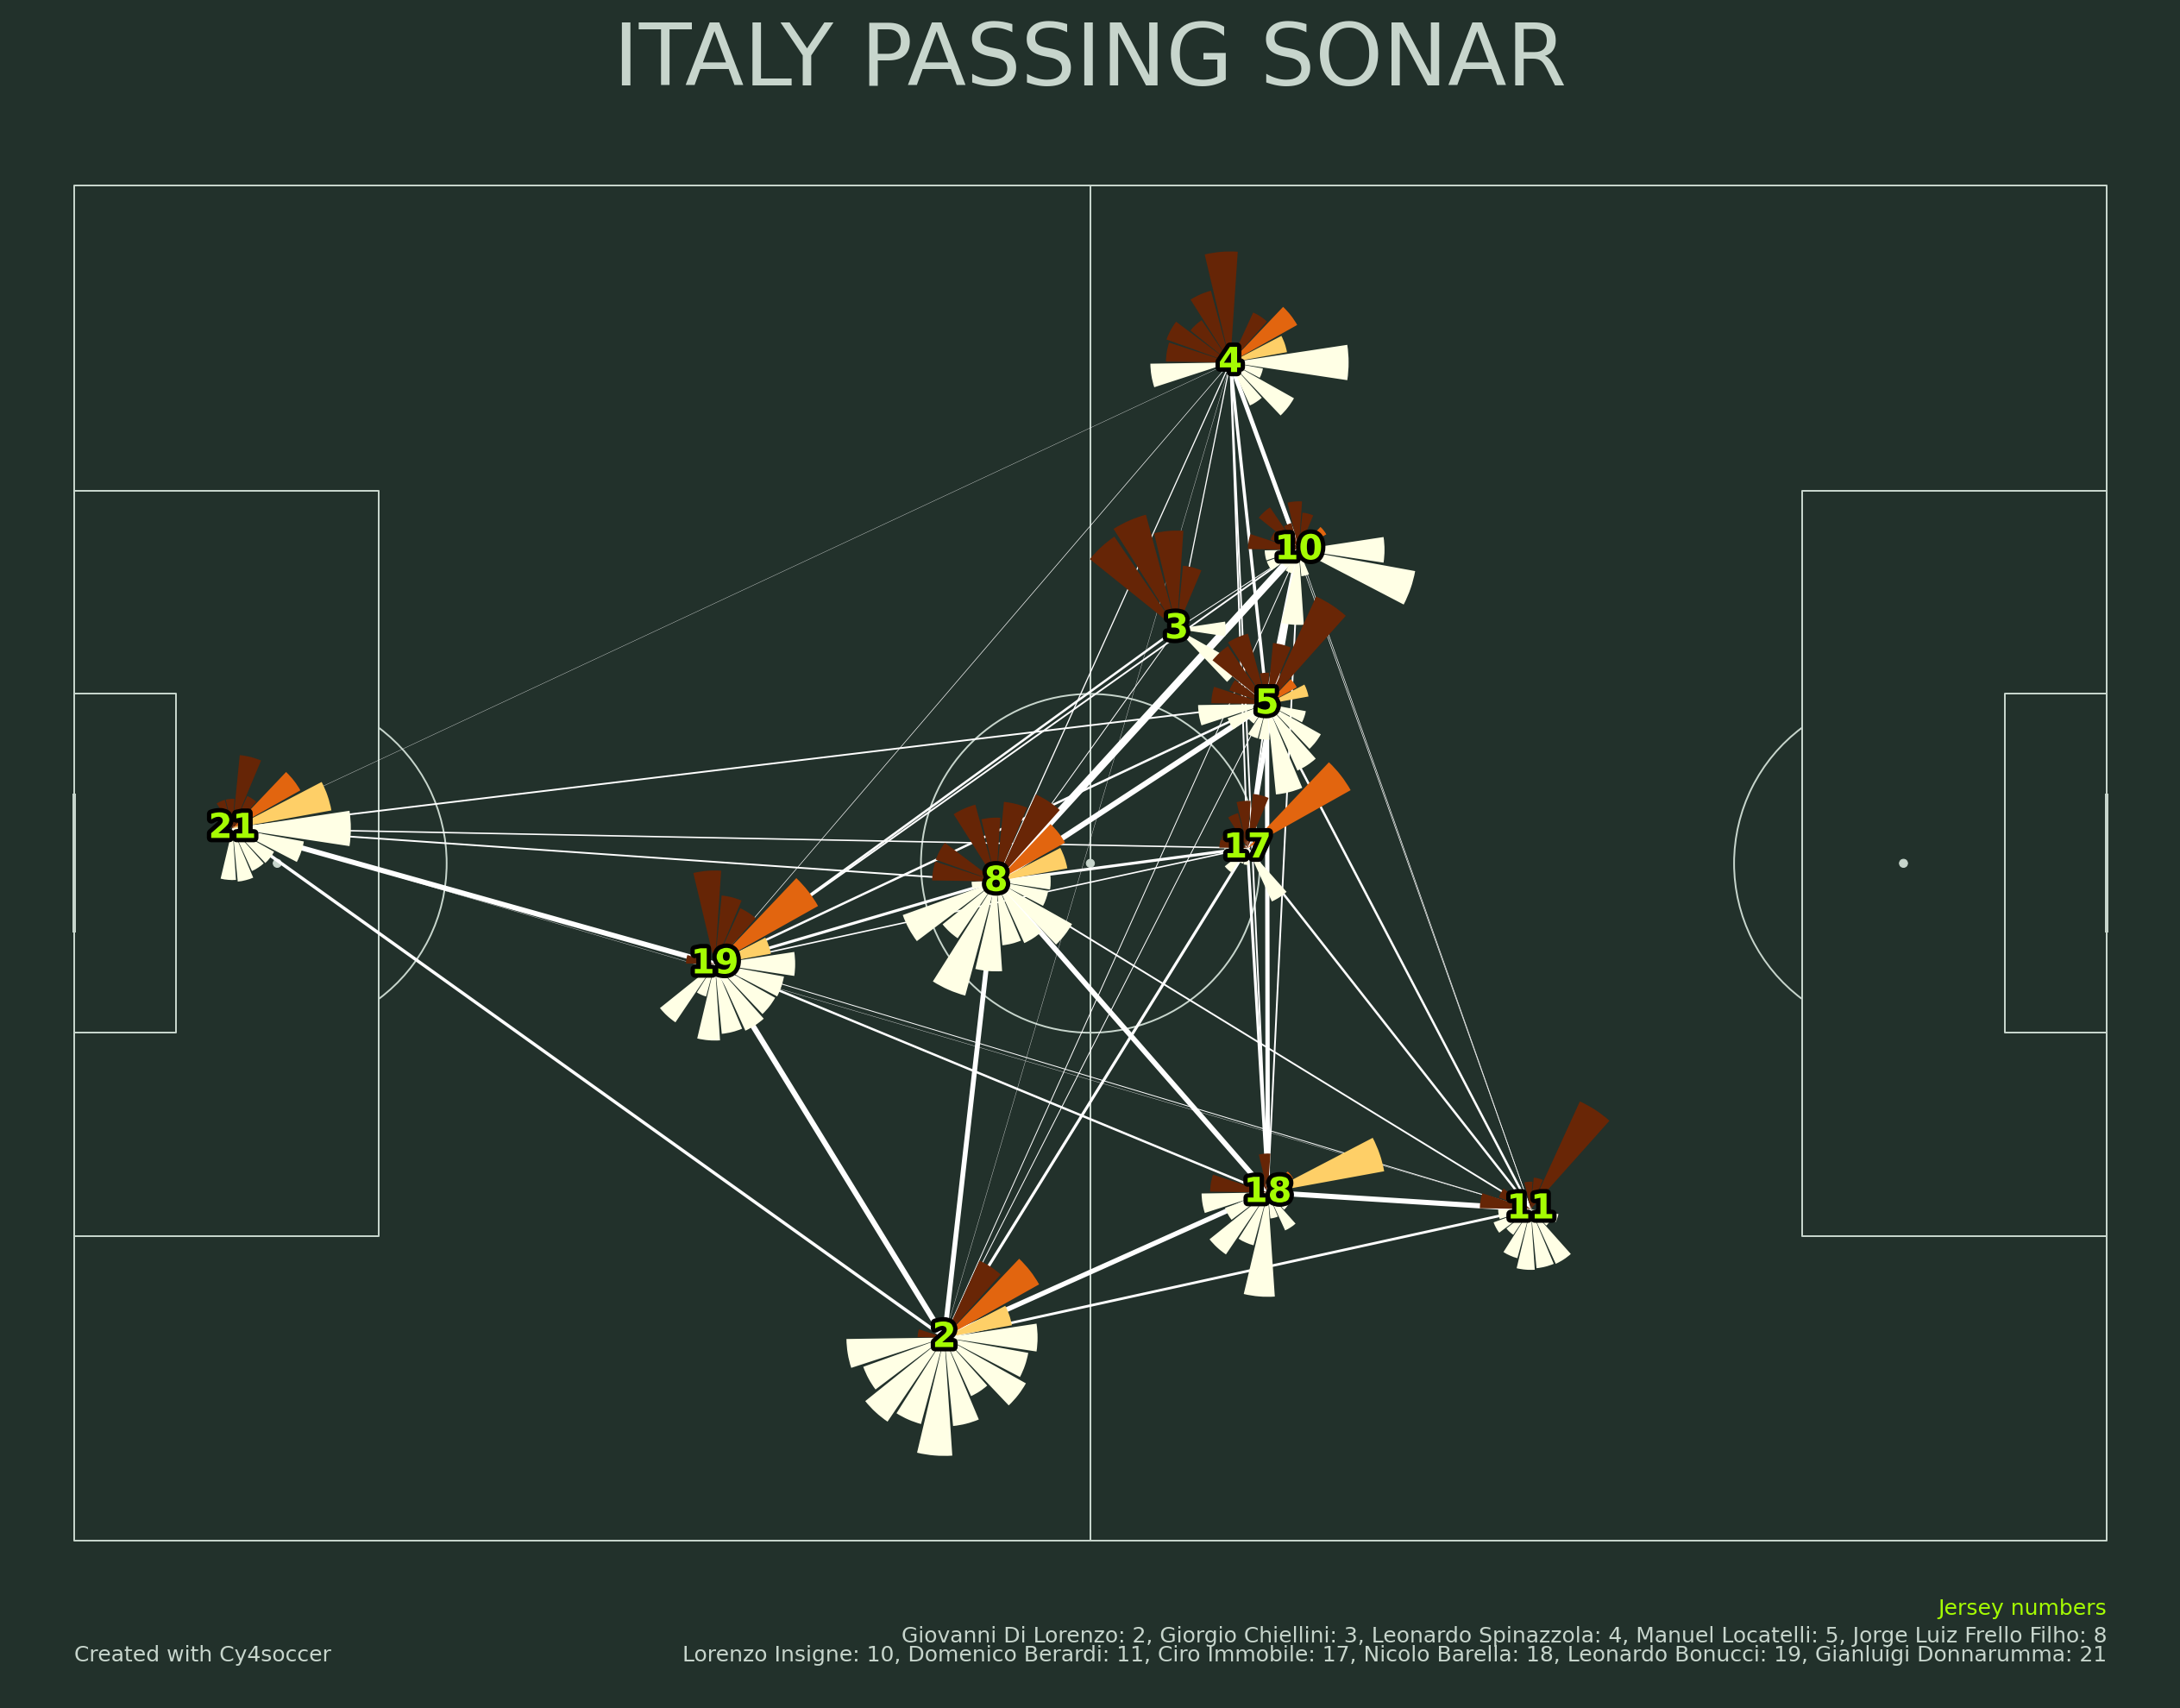

In [28]:
get_team_sonar(team_dict, TEAM, MATCH_ID, app, player_to_jersey_mapping, df)